In [0]:
# %pip install tensorflow==1.13.1

In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow.keras.backend as K
from keras.models import Sequential,Model
from keras.layers import Conv2D,MaxPooling2D
from keras.layers import Activation, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import plot_model

from os import listdir
from os.path import isfile, join
from PIL import Image
import glob

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

Using TensorFlow backend.


## Loading of Data

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !ls '/content/drive/My Drive/Colab Notebooks/Data/OCT 2017'

test  train  val


In [0]:
train_path = '/content/drive/My Drive/Colab Notebooks/Data/OCT 2017/train'
train_cnv_pth = os.path.join(train_path, 'CNV')
train_normal_pth = os.path.join(train_path, 'NORMAL')
train_dme_pth = os.path.join(train_path, 'DME')
train_drusen_pth = os.path.join(train_path, 'DRUSEN')


test_path = '/content/drive/My Drive/Colab Notebooks/Data/OCT 2017/test'
test_cnv_pth = os.path.join(test_path, 'CNV')
test_normal_pth = os.path.join(test_path, 'NORMAL')
test_dme_pth = os.path.join(test_path, 'DME')
test_drusen_pth = os.path.join(test_path, 'DRUSEN')

val_path = '/content/drive/My Drive/Colab Notebooks/Data/OCT 2017/val'
val_cnv_pth = os.path.join(val_path, 'CNV')
val_normal_pth = os.path.join(val_path, 'NORMAL')
val_dme_pth = os.path.join(val_path, 'DME')
val_drusen_pth = os.path.join(val_path, 'DRUSEN')

## Data Augmentation

In [0]:
def process_data(img_dim, batch_size):
    # Data generation objects
    train_datagen = ImageDataGenerator(rescale=1./255,
                                       zoom_range=0.3, horizontal_flip=True, validation_split=0.2)
    
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    
    # This is fed to the network in the specified batch sizes and image dimensions
    train_gen = train_datagen.flow_from_directory(directory=test_path, 
                                                  target_size=(img_dim,img_dim), 
                                                  batch_size=batch_size, 
                                                  class_mode = 'categorical', 
                                                  subset='training',
                                                  shuffle=True)

    test_gen = test_datagen.flow_from_directory(directory=test_path, 
                                                target_size=(img_dim,img_dim), 
                                                batch_size=batch_size, 
                                                class_mode='categorical', 
                                                subset='validation',
                                                shuffle=True)


    test_data = []
    test_labels = []

    for cond in ['/NORMAL/', '/DME/', '/DRUSEN/', '/CNV/']:
        for img in (os.listdir(test_path + cond)):
            img = plt.imread(test_path + cond + img)
            img = cv2.resize(img, (img_dim, img_dim))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond=='/NORMAL/':
                label = 0
            elif cond=='/DME/':
                label = 1
            elif cond=='/DRUSEN/':
                label = 2
            elif cond=='/CNV/':
                label = 3
            test_data.append(img)
            test_labels.append(label)
        
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_gen, test_gen, test_data, test_labels

In [ ]:
PARAMS = {'img_dims': 160,
          'epochs': 100,
          'batch_size': 32,
          'optimizer': 'adam',
          'loss': 'categorical_crossentropy',
          'metrics': 'accuracy',
          }

In [ ]:
from sklearn.utils import class_weight

train_gen, test_gen, test_data, test_labels = process_data(PARAMS['img_dims'], PARAMS['batch_size'])

#create class weights for unbalanced dataset
y_train = train_gen.classes
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = dict(enumerate(class_weights))

## Model Initialisation

In [0]:
from keras.applications.vgg16 import VGG16

model = VGG16(weights = "imagenet", include_top=False, input_shape=(PARAMS['img_dims'], PARAMS['img_dims'], 3))

# Freeze front layers
for layer in model.layers:
    layer.trainable = False

# Adding FC layers 
x = model.output
x = Flatten()(x)
# x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)

model = Model(inputs=model.input, outputs=predictions)

In [21]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 160, 160, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0   

In [0]:
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [0]:
import keras

es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

## Training Model

In [0]:
history = model.fit_generator(train_gen, epochs=PARAMS['epochs'],
                              steps_per_epoch=train_gen.samples // PARAMS['batch_size'],
                              validation_data=test_gen,
                             validation_steps=30,
                              callbacks=[es],
                             class_weight=class_weights)

Epoch 1/100
24/24 [==============================] - 626s 26s/step - loss: 1.2968 - acc: 0.4182 - val_loss: 0.9748 - val_acc: 0.6881
Epoch 2/100
24/24 [==============================] - 637s 27s/step - loss: 0.8587 - acc: 0.7061 - val_loss: 0.8333 - val_acc: 0.6750
Epoch 3/100
24/24 [==============================] - 656s 27s/step - loss: 0.6745 - acc: 0.7883 - val_loss: 0.6419 - val_acc: 0.8000
Epoch 4/100
 8/24 [=========>....................] - ETA: 3:34 - loss: 0.5547 - acc: 0.8359

In [0]:
print ('Train Accuracy', np.mean(history.history['acc']))
print ('Train Loss', np.mean(history.history['loss']))
print ('Test Accuracy', np.mean(history.history['val_acc']))
print ('Test Loss', np.mean(history.history['val_loss']))

Train Accuracy 0.8794273208181934
Train Loss 0.32501838285427903
Test Accuracy 0.8843217225161669
Test Loss 0.30954637791564504


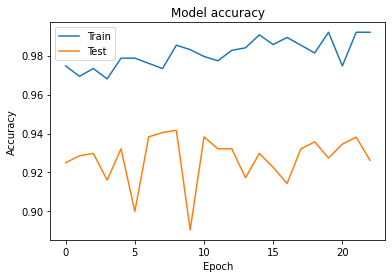

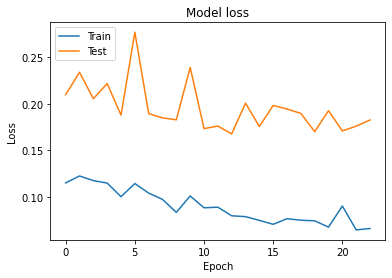

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
model.save_weights('trial1')